In [7]:
import glob
import os


import numpy as np
import nibabel as nib
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

import medtool.data.mnm_dataset as mnm_dataset

In [34]:
model = torch.load('../models/mnm_unetpp_se_resnext50_32x4d.pt')
model.to('cuda')
model.eval();

In [153]:
la_ed    = np.moveaxis(nib.load('../../MnM-2/validation/166/166_SA_ED.nii.gz').get_fdata(), -1, 0)
la_ed_gt = np.moveaxis(nib.load('../../MnM-2/training/001/001_SA_ED_gt.nii.gz').get_fdata(), -1, 0)

la_es    = np.moveaxis(nib.load('../../MnM-2/training/001/001_SA_ES.nii.gz').get_fdata(), -1, 0)

In [154]:
la_ed.shape, \
la_es.shape

((11, 256, 208), (12, 256, 256))

In [155]:
test_dataset = mnm_dataset.MnM(
    la_ed
)

In [156]:
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    drop_last=False,
)

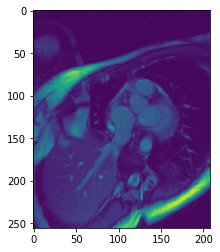

In [157]:
plt.imshow(la_ed[0, :, :])

In [190]:
def get_mask(img, original_shape):
    summed_up_masks = np.zeros(img[0].shape)
    for ind, i in enumerate(img):
        inversed_summed_up = ~ ((summed_up_masks).astype(bool))
        summed_up_masks += (i > 0.4) * inversed_summed_up * (ind + 1)
    res = np.zeros(original_shape)
    if original_shape[0] < 256 or original_shape[1] < 256:
        res = summed_up_masks[:original_shape[0], :original_shape[1]]
    else:
        res[:summed_up_masks.shape[0], :summed_up_masks.shape[1]] = summed_up_masks
    return res

In [191]:
def pad_with_zeros(img):
    if img.shape[-1] < 256:
        zeros = torch.zeros((1, 1, img.shape[-2], 256))
        zeros[0][0][:img.shape[-2], :img.shape[-1]] = img
        img = zeros
    if img.shape[-2] < 256:
        zeros = torch.zeros((1, 1, 256, img.shape[-1]))
        zeros[0][0][:img.shape[-2], :img.shape[-1]] = img
        img = zeros
    return img

In [192]:
result = []
for one_slice in test_loader:
    original_shape = np.array(one_slice[0][0].shape)
    one_slice = pad_with_zeros(one_slice)
    one_slice = one_slice[:, :, :320, :320].to('cuda')
    output = model(one_slice)[0]
    
    stacked_mask = get_mask(output.detach().cpu().numpy(), original_shape)
    result.append(stacked_mask)
    
result = np.moveaxis(np.array(result), 0, -1)

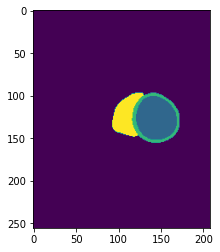

In [194]:
plt.imshow(result[:, :, 5])

In [ ]:
nib.save(nib.Nifti1Image(result, nifty_image.affine, nifty_image.header), os.path.join(outputDir, sub + '_seg_result.nii.gz'))

In [2]:
la_cine  = nib.load('../../MnM-2/training/001/001_LA_CINE.nii.gz').get_fdata()

la_ed = nib.load('../../MnM-2/training/001/001_LA_ED.nii.gz').get_fdata()
la_ed_gt = nib.load('../../MnM-2/training/001/001_LA_ED_gt.nii.gz').get_fdata()

la_es = nib.load('../../MnM-2/training/001/001_LA_ES.nii.gz').get_fdata()
la_es_gt = nib.load('../../MnM-2/training/001/001_LA_ES_gt.nii.gz').get_fdata()

In [23]:
np.squeeze([np.moveaxis(np.asarray(nib.load('../../MnM-2/training/001/001_LA_ED.nii.gz').dataobj), -1, 0)]).shape

(256, 256)

In [3]:
la_cine.shape, \
la_ed.shape, \
la_ed_gt.shape

((256, 256, 1, 25), (256, 256, 1), (256, 256, 1))

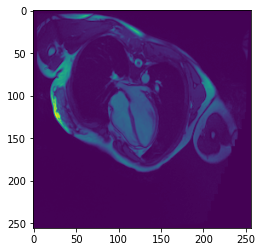

In [4]:
plt.imshow(la_cine[:, :, 0, 24])

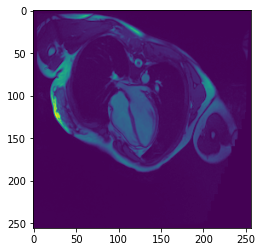

In [5]:
plt.imshow(la_ed[:, :, 0])

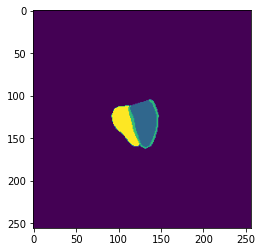

In [6]:
plt.imshow(la_ed_gt[:, :, 0])

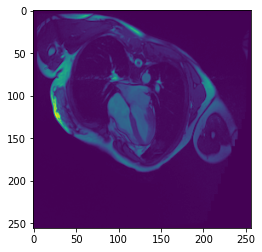

In [7]:
plt.imshow(la_es[:, :, 0])

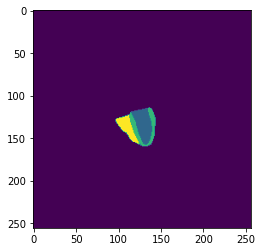

In [8]:
plt.imshow(la_es_gt[:, :, 0])

In [9]:
np.unique(la_ed_gt)

array([0., 1., 2., 3.])